In [ ]:
import csv
from bio_embeddings.embed import ProtTransBertBFDEmbedder

# Initialize the ProtTrans Bert BFD embedder
embedder = ProtTransBertBFDEmbedder()

# Read sequences from the CSV file
genes = {}
with open('datas/gene_sequence.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        gene_name, sequence = row
        genes[gene_name] = sequence

# Embed the sequences and get the reduced (pooled) embeddings
embeddings = {}
for idx, (gene, sequence) in enumerate(genes.items()):
    print(f"Embedding sequence {idx + 1}/{len(genes)}: {gene}")
    try:
        sequence_embedding = embedder.embed(sequence)
    except RuntimeError as e:
        # Fallback to CPU embedding in case of a CUDA error
        print(f"Warning: {e}. Falling back to CPU for embedding sequence: {gene}")
        cpu_embedder = ProtTransBertBFDEmbedder(device="cpu")
        sequence_embedding = cpu_embedder.embed(sequence)
    
    # Pool the embeddings to get a fixed-length vector representation for the entire sequence
    pooled_embedding = sequence_embedding.mean(axis=0)
    embeddings[gene] = pooled_embedding

    # Save the pooled embeddings to a CSV file
    with open("datas/gene_embeddings.txt", 'a') as f:
        f.write(f'{gene},{pooled_embedding}\n')



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr



class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # dimensions for the intermediate layers
        #dims = [input_dim, int(input_dim*1.2), int(input_dim*1.5), int(input_dim*1.3), int(input_dim*0.9), int(input_dim*0.75), int(input_dim*0.5), int(input_dim*0.25), latent_dim]
        dims = [input_dim, int(input_dim*1.5), int(input_dim*0.75), int(input_dim*0.5), int(input_dim*0.25), latent_dim]

        # Encoder layers with BatchNorm
        encoder_layers = []
        for i in range(len(dims)-1):
            encoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            encoder_layers.append(nn.BatchNorm1d(dims[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space layers
        self.fc_mu = nn.Linear(dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(dims[-1], latent_dim)

        # Decoder layers with BatchNorm
        decoder_layers = []
        for i in range(len(dims)-2, -1, -1):
            decoder_layers.append(nn.Linear(dims[i+1], dims[i]))
            decoder_layers.append(nn.BatchNorm1d(dims[i]))
            decoder_layers.append(nn.ReLU())
            #print(len(decoder_layers))
        decoder_layers.append(nn.Sigmoid()) 
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        output = self.decoder(z)
        return output

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar




def create_dataloader(train_tensor, batch_size):
    dataset = TensorDataset(train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader




def kl_divergence(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def pearson_correlation(x, y):
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))

def cosine_similarity(A, B):
    dot_product = torch.sum(A * B)
    norm_a = torch.norm(A)
    norm_b = torch.norm(B)
    return dot_product / (norm_a * norm_b)

reconstruction_loss = nn.MSELoss()


device = ("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ', device)

filename = '/mnt/data/macaulay/datas/processed_OmicsExpression.csv'
df = pd.read_csv(filename)
cell_line_names = df['Cell_line'].copy()  
df = df.drop(columns=['Cell_line'])
numeric_data = df.values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Split the data
train_data, val_data = train_test_split(scaled_data, test_size=0.2)  
train_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
val_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)



input_dim = train_tensor.shape[1]

def train_model(vae, train_loader, val_loader, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    cosine_similarities = []
    
    for epoch in range(num_epochs):
        vae.train()
        running_loss = 0.0
        for batch_data in train_loader:
            optimizer.zero_grad()
            batch_data = batch_data[0].to(device)
            output, mu, logvar = vae(batch_data)
            recon_loss = reconstruction_loss(output, batch_data)
            kl_loss = kl_divergence(mu, logvar)
            combined_loss = recon_loss + kl_loss
            combined_loss.backward()
            optimizer.step()
            running_loss += combined_loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        
        vae.eval()
        running_loss = 0.0
        reconstructed_data = []
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data[0].to(device)
                output, mu, logvar = vae(batch_data)
                recon_loss = reconstruction_loss(output, batch_data)
                kl_loss = kl_divergence(mu, logvar)
                combined_loss = recon_loss + kl_loss
                running_loss += combined_loss.item()
                reconstructed_data.append(output)
                
        val_losses.append(running_loss / len(val_loader))
        
        reconstructed_data = torch.cat(reconstructed_data, dim=0)
        epoch_cosine_similarity = cosine_similarity(reconstructed_data, val_tensor).item()
        cosine_similarities.append(epoch_cosine_similarity)
        
        # Print metrics
        
        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Cosine Similarity: {epoch_cosine_similarity:.4f}")
        
    return train_losses, val_losses, cosine_similarities


    
# Grid Search
best_val_loss = float('inf')
best_params = None

latent_dims = [512, 1024, 2048]
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32, 64]
num_epochs = 30

for latent_dim in latent_dims:
    for lr in learning_rates:
        print(f"Training with latent_dim: {latent_dim}, learning_rate: {lr}, batch_size: {batch}")
        for batch in batch_sizes:
            #print(f"Training with latent_dim: {latent_dim}, learning_rate: {lr}, batch_size: {batch}")
            
            vae = VAE(input_dim, latent_dim).to(device)
            optimizer = optim.Adam(vae.parameters(), lr=lr)
            train_loader = create_dataloader(train_tensor, batch)
            val_loader = create_dataloader(val_tensor, batch)
            
            train_losses, val_losses = train_model(vae, train_loader, val_loader, optimizer, num_epochs)
            
            final_val_loss = val_losses[-1]
            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                best_params = (latent_dim, lr, batch)

print(f"Best hyperparameters: latent_dim: {best_params[0]}, learning_rate: {best_params[1]}, batch_size: {best_params[2]} with validation loss: {best_val_loss}")



df shape: (1001, 17643)
training tensor data shape: torch.Size([1001, 17643])
Using:  cuda
Epoch [1/100], Combined Training Loss: 26361.9132, Reconstruction Loss: 1.2799, KL Loss: 26360.6334, Correlation: -0.0075


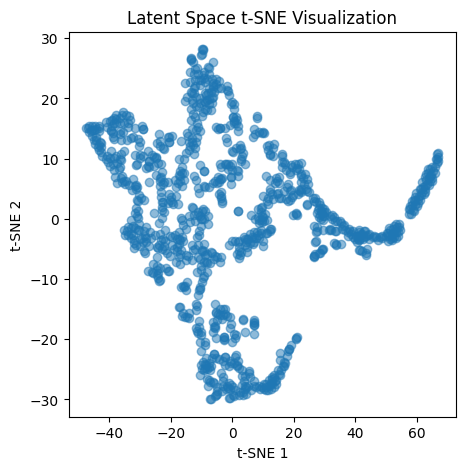

Epoch [2/100], Combined Training Loss: 1435.6930, Reconstruction Loss: 1.2516, KL Loss: 1434.4414, Correlation: -0.0018
Epoch [3/100], Combined Training Loss: 178.6596, Reconstruction Loss: 1.2492, KL Loss: 177.4104, Correlation: -0.0007
Epoch [4/100], Combined Training Loss: 68.4807, Reconstruction Loss: 1.2491, KL Loss: 67.2316, Correlation: 0.0001
Epoch [5/100], Combined Training Loss: 37.6711, Reconstruction Loss: 1.2491, KL Loss: 36.4220, Correlation: 0.0006
Epoch [6/100], Combined Training Loss: 25.9107, Reconstruction Loss: 1.2491, KL Loss: 24.6616, Correlation: -0.0014
Epoch [7/100], Combined Training Loss: 30.5351, Reconstruction Loss: 1.2491, KL Loss: 29.2860, Correlation: 0.0021
Epoch [8/100], Combined Training Loss: 15.7054, Reconstruction Loss: 1.2491, KL Loss: 14.4563, Correlation: -0.0003
Epoch [9/100], Combined Training Loss: 19.3804, Reconstruction Loss: 1.2491, KL Loss: 18.1313, Correlation: -0.0006
Epoch [10/100], Combined Training Loss: 20.9687, Reconstruction Loss:

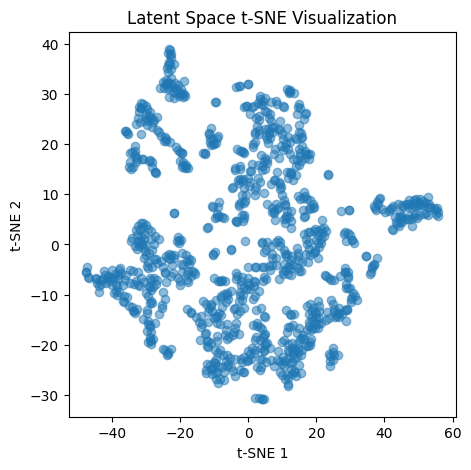

Epoch [12/100], Combined Training Loss: 36.6741, Reconstruction Loss: 1.2491, KL Loss: 35.4250, Correlation: -0.0005
Epoch [13/100], Combined Training Loss: 81.5166, Reconstruction Loss: 1.2491, KL Loss: 80.2675, Correlation: -0.0002
Epoch [14/100], Combined Training Loss: 39.3408, Reconstruction Loss: 1.2491, KL Loss: 38.0917, Correlation: -0.0005
Epoch [15/100], Combined Training Loss: 68.9906, Reconstruction Loss: 1.2491, KL Loss: 67.7415, Correlation: -0.0001
Epoch [16/100], Combined Training Loss: 81.9290, Reconstruction Loss: 1.2491, KL Loss: 80.6799, Correlation: -0.0009
Epoch [17/100], Combined Training Loss: 49.8451, Reconstruction Loss: 1.2491, KL Loss: 48.5960, Correlation: 0.0002
Epoch [18/100], Combined Training Loss: 57.3659, Reconstruction Loss: 1.2491, KL Loss: 56.1169, Correlation: -0.0003
Epoch [19/100], Combined Training Loss: 54.2893, Reconstruction Loss: 1.2491, KL Loss: 53.0402, Correlation: -0.0003
Epoch [20/100], Combined Training Loss: 46.5788, Reconstruction L

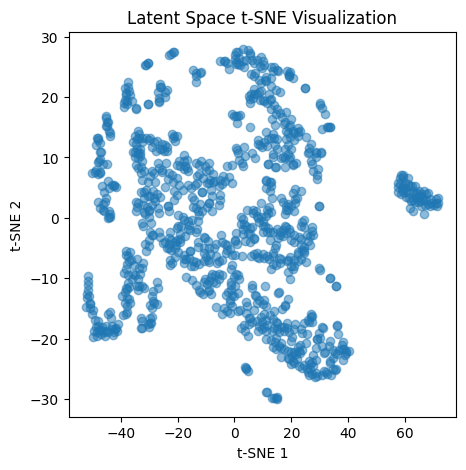

Epoch [22/100], Combined Training Loss: 53.1201, Reconstruction Loss: 1.2491, KL Loss: 51.8710, Correlation: 0.0006
Epoch [23/100], Combined Training Loss: 80.3899, Reconstruction Loss: 1.2491, KL Loss: 79.1409, Correlation: 0.0003
Epoch [24/100], Combined Training Loss: 25.6232, Reconstruction Loss: 1.2491, KL Loss: 24.3742, Correlation: -0.0005
Epoch [25/100], Combined Training Loss: 19.4862, Reconstruction Loss: 1.2491, KL Loss: 18.2371, Correlation: -0.0007
Epoch [26/100], Combined Training Loss: 142.3032, Reconstruction Loss: 1.2491, KL Loss: 141.0541, Correlation: -0.0019
Epoch [27/100], Combined Training Loss: 134.5890, Reconstruction Loss: 1.2491, KL Loss: 133.3399, Correlation: 0.0001
Epoch [28/100], Combined Training Loss: 207.4496, Reconstruction Loss: 1.2491, KL Loss: 206.2005, Correlation: -0.0003


KeyboardInterrupt: 

: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from pptx import Presentation
from pptx.util import Inches



class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # dimensions for the intermediate layers
        dims = [input_dim, int(input_dim*1.3), int(input_dim*1.2), int(input_dim*1), int(input_dim*0.5), int(input_dim*0.3), latent_dim, latent_dim]

        # Encoder layers with BatchNorm
        encoder_layers = []
        for i in range(len(dims)-1):
            encoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            encoder_layers.append(nn.BatchNorm1d(dims[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space layers
        self.fc_mu = nn.Linear(dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(dims[-1], latent_dim)

        # Decoder layers with BatchNorm
        decoder_layers = []
        for i in range(len(dims)-2, -1, -1):
            decoder_layers.append(nn.Linear(dims[i+1], dims[i]))
            decoder_layers.append(nn.BatchNorm1d(dims[i]))
            decoder_layers.append(nn.ReLU())
            #print(len(decoder_layers))
        decoder_layers.append(nn.Sigmoid()) 
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        output = self.decoder(z)
        return output

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar




def create_dataloader(train_tensor, batch_size):
    dataset = TensorDataset(train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader




def kl_divergence(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def pearson_correlation(x, y):
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))






filename = '/mnt/data/macaulay/datas/processed_OmicsExpression.csv'
df = pd.read_csv(filename)
cell_line_names = df['Cell_line'].copy()  # Save the 'Cell_line' column
df = df.drop(columns=['Cell_line'])

numeric_data = df.values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
train_tensor = torch.tensor(scaled_data, dtype=torch.float32)
print("df shape:", df.shape)
print('training tensor data shape:', train_tensor.shape)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ', device)

train_tensor = train_tensor.to(device)


input_dim = train_tensor.shape[1]
learning_rate = 0.00001
batch_size = 16
num_epochs = 1000

latent_dim = 1024



prs = Presentation()
vae = VAE(input_dim, latent_dim)
vae = vae.to(device)
reconstruction_loss = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
dataloader = create_dataloader(train_tensor, batch_size)

recon_loss = []
train_losses = []
embeddings_list = []
kl_losses = []
correlations = []
for epoch in range(num_epochs):
    vae.train()
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    reconstructed_data = []

    for batch_data in dataloader:
        optimizer.zero_grad()
        batch_data = batch_data[0].to(device)

        # Forward pass
        output, mu, logvar = vae(batch_data)
        reconstructed_data.append(output.detach())

        recon_loss = reconstruction_loss(output, batch_data)
        kl_loss = kl_divergence(mu, logvar)
 
        # Combined loss
        combined_loss = recon_loss + kl_loss

        # Backward pass and optimization
        combined_loss.backward()
        optimizer.step()

        # Accumulate running losses
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        embeddings = mu.detach().cpu().numpy()
        embeddings_list.append(embeddings)


    # After all batches are processed, compute correlation over the entire dataset
    reconstructed_data = torch.cat(reconstructed_data, dim=0)
    epoch_correlation = pearson_correlation(reconstructed_data, train_tensor).item()
    correlations.append(epoch_correlation)

    # Print epoch statistics
    epoch_recon_loss = running_recon_loss / len(dataloader)
    epoch_kl_loss = running_kl_loss / len(dataloader)
    epoch_combined_loss = epoch_recon_loss + epoch_kl_loss

    print(f"Epoch [{epoch + 1}/{num_epochs}], Combined Training Loss: {epoch_combined_loss:.4f}, Reconstruction Loss: {epoch_recon_loss:.4f}, KL Loss: {epoch_kl_loss:.4f}, Correlation: {epoch_correlation:.4f}")

    recon_loss.append(epoch_recon_loss)
    train_losses.append(epoch_combined_loss)
    kl_losses.append(epoch_kl_loss)


    if epoch % 10 == 0:


        vae.eval()
        

        # Encode the entire dataset to get the latent variables
        with torch.no_grad():
            mu, _ = vae.encode(train_tensor)

        mu = mu.cpu().numpy()

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(mu)

        # Plot t-SNE results
        plt.figure(figsize=(5, 5))
        plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.5)
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.title(f'Latent Space t-SNE Visualization of epoch {epoch+1}')
        tmp_img_path = f'/mnt/data/macaulay/plot_images/tnse{epoch}.png'
        plt.savefig(tmp_img_path)
        plt.close()

        # Add a slide and insert the image
        slide_layout = prs.slide_layouts[5]  # Blank slide layout
        slide = prs.slides.add_slide(slide_layout)
        slide.shapes.add_picture(tmp_img_path, Inches(1), Inches(1), width=Inches(5.5))

    with open('/mnt/data/macaulay/datas/vae_expression.txt', 'a') as f:
        if epoch == 0:
            f.write(f'Epoch,Combined Training Loss,Reconstruction Loss,KL Loss,Correlation\n')
            f.write(f'{epoch+1},{epoch_combined_loss:.4f},{epoch_recon_loss:.4f},{epoch_kl_loss:.4f},{epoch_correlation:.4f}\n')
        else:
            f.write(f'{epoch+1},{epoch_combined_loss:.4f},{epoch_recon_loss:.4f},{epoch_kl_loss:.4f},{epoch_correlation:.4f}\n')
    if epoch % 10 == 0:
        embeddings_array = np.concatenate(embeddings_list)
        df_embeddings = pd.DataFrame(embeddings_array)

        df_embeddings = pd.concat([cell_line_names, df_embeddings], axis=1) #join the cell line names to the embeddings
        df_embeddings.to_csv(f'/mnt/data/macaulay/datas/OmicExpression_embeddings/OmicExpression_embeddings_{epoch+1}.csv', index=False)


# Save the updated VAE model
torch.save(vae.state_dict(), '/mnt/data/macaulay/vae_state/vae_expression.pth')

plt.plot(range(2, num_epochs + 1), recon_loss[1:], label='Combined Training Loss')
plt.plot(range(2, num_epochs + 1), kl_losses[1:], label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.savefig('/mnt/data/macaulay/plot_images/vae_loss_curve.png')


prs.save("/mnt/data/latent_space_visualization.pptx")


In [5]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from pptx import Presentation
from pptx.util import Inches



class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # dimensions for the intermediate layers
        dims = [input_dim, int(input_dim*1.3), int(input_dim*1.2), int(input_dim*1), int(input_dim*0.5), int(input_dim*0.3), latent_dim, latent_dim]

        # Encoder layers with BatchNorm
        encoder_layers = []
        for i in range(len(dims)-1):
            encoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            encoder_layers.append(nn.BatchNorm1d(dims[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space layers
        self.fc_mu = nn.Linear(dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(dims[-1], latent_dim)

        # Decoder layers with BatchNorm
        decoder_layers = []
        for i in range(len(dims)-2, -1, -1):
            decoder_layers.append(nn.Linear(dims[i+1], dims[i]))
            decoder_layers.append(nn.BatchNorm1d(dims[i]))
            decoder_layers.append(nn.ReLU())
            #print(len(decoder_layers))
        decoder_layers.append(nn.Sigmoid()) 
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        output = self.decoder(z)
        return output

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar




def create_dataloader(train_tensor, batch_size):
    dataset = TensorDataset(train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader




def kl_divergence(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def pearson_correlation(x, y):
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))






filename = '/mnt/data/macaulay/datas/processed_OmicsExpression.csv'
df = pd.read_csv(filename)
cell_line_names = df['Cell_line'].copy()  # Save the 'Cell_line' column
df = df.drop(columns=['Cell_line'])

numeric_data = df.values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
train_tensor = torch.tensor(scaled_data, dtype=torch.float32)
print("df shape:", df.shape)
print('training tensor data shape:', train_tensor.shape)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ', device)

train_tensor = train_tensor.to(device)


input_dim = train_tensor.shape[1]
learning_rate = 0.00001
batch_size = 16
num_epochs = 10

latent_dim = 1024



# prs = Presentation()
vae = VAE(input_dim, latent_dim)
vae = vae.to(device)
reconstruction_loss = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
dataloader = create_dataloader(train_tensor, batch_size)

reconst_loss = []
train_losses = []

kl_losses = []
correlations = []
for epoch in range(num_epochs):
    embeddings_list = []
    vae.train()
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    reconstructed_data = []

    for batch_data in dataloader:
        optimizer.zero_grad()
        batch_data = batch_data[0].to(device)

        # Forward pass
        output, mu, logvar = vae(batch_data)
        reconstructed_data.append(output.detach())

        recon_loss = reconstruction_loss(output, batch_data)
        kl_loss = kl_divergence(mu, logvar)
 
        # Combined loss
        combined_loss = recon_loss + kl_loss

        # Backward pass and optimization
        combined_loss.backward()
        optimizer.step()

        # Accumulate running losses
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        embeddings = mu.detach().cpu().numpy()
        embeddings_list.append(embeddings)


    # After all batches are processed, compute correlation over the entire dataset
    reconstructed_data = torch.cat(reconstructed_data, dim=0)
    epoch_correlation = pearson_correlation(reconstructed_data, train_tensor).item()
    correlations.append(epoch_correlation)

    # Print epoch statistics
    epoch_recon_loss = running_recon_loss / len(dataloader)
    epoch_kl_loss = running_kl_loss / len(dataloader)
    epoch_combined_loss = epoch_recon_loss + epoch_kl_loss

    print(f"Epoch [{epoch + 1}/{num_epochs}], Combined Training Loss: {epoch_combined_loss:.4f}, Reconstruction Loss: {epoch_recon_loss:.4f}, KL Loss: {epoch_kl_loss:.4f}, Correlation: {epoch_correlation:.4f}")

    reconst_loss.append(epoch_recon_loss)
    train_losses.append(epoch_combined_loss)
    kl_losses.append(epoch_kl_loss)


    embeddings_array = np.concatenate(embeddings_list)
    df_embeddings = pd.DataFrame(embeddings_array)

    df_embeddings = pd.concat([cell_line_names, df_embeddings], axis=1) #join the cell line names to the embeddings
    df_embeddings.to_csv(f'/mnt/data/macaulay/datas/OmicExpression_embeddings/OmicExpression_embeddings_{epoch}.csv', index=False)


# # # Save the updated VAE model
# # torch.save(vae.state_dict(), '/mnt/data/macaulay/vae_state/vae_expression.pth')

# plt.plot(range(2, num_epochs + 1), reconst_loss[1:], label='Combined Training Loss')
# plt.plot(range(2, num_epochs + 1), kl_losses[1:], label='KL Divergence')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Curves')
# plt.legend()
# plt.savefig('/mnt/data/macaulay/plot_images/vae_loss_curve.png')


# prs.save("/mnt/data/macaulay/datas/latent_space_visualization.pptx")


df shape: (1001, 17643)
training tensor data shape: torch.Size([1001, 17643])
Using:  cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.51 GiB (GPU 0; 79.15 GiB total capacity; 55.00 GiB already allocated; 763.75 MiB free; 55.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
import pandas as pd
df = pd.read_csv('/home/macaulay/macaulay/GenePedia/datas/gene_correlations.txt')
df

,Epoch,gene,correlation
0,Epoch1,MTREX,-0.1138
1,Epoch,gene,correlation
2,Epoch1,YAF2,0.2457
3,Epoch,gene,correlation
4,Epoch1,RNF19A,0.0931
...,...,...,...
629994,Epoch1,CHMP4A,0.1452
629995,Epoch,gene,correlation
629996,Epoch1,WFDC6,-0.1486
629997,Epoch,gene,correlation


In [12]:
# Filter out rows where 'Epoch' is not equal to 'Epoch1'
df = df[df['Epoch'] == 'Epoch1']

# Reset the index
df.reset_index(drop=True, inplace=True)

df

,Epoch,gene,correlation
0,Epoch1,MTREX,-0.1138
1,Epoch1,YAF2,0.2457
2,Epoch1,RNF19A,0.0931
3,Epoch1,AASS,-0.2097
4,Epoch1,NOX1,-0.0507
...,...,...,...
314995,Epoch1,TIFAB,0.1871
314996,Epoch1,PSG4,0.1430
314997,Epoch1,CHMP4A,0.1452
314998,Epoch1,WFDC6,-0.1486


In [15]:
# Calculate the mean of the 'correlation' column
correlation_mean = df['correlation'].astype(float).mean()

print("Mean of the 'correlation' column:", correlation_mean)

Mean of the 'correlation' column: 0.0018151473015873018


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

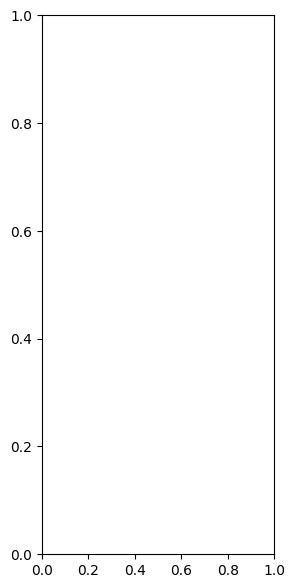

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the Pearson correlation data
pearson_data = df['correlation']

# Create a boxplot
plt.figure(figsize=(3,7))
plt.boxplot(pearson_data)
plt.title('Boxplot of Pearson Correlation')
plt.xlabel('Variable')
plt.ylabel('Pearson Correlation')
plt.xticks([1], ['correlation'])

plt.show()

/tmp/ipykernel_955884/1408734862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correlation'] = pd.to_numeric(df['correlation'])


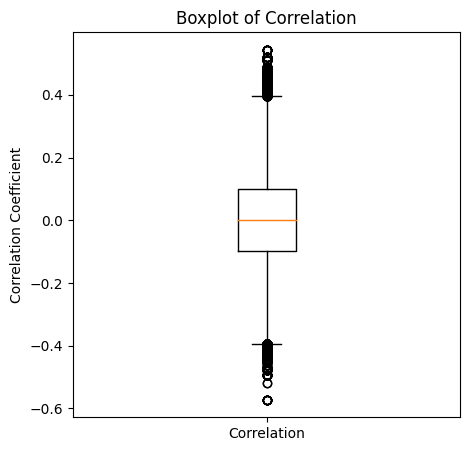

In [18]:
# Convert 'correlation' column to numeric
df['correlation'] = pd.to_numeric(df['correlation'])

# Create a boxplot
plt.figure(figsize=(5, 5))
plt.boxplot(df['correlation'])
plt.title('Boxplot of Correlation')
plt.ylabel('Correlation Coefficient')
plt.xticks([1], ['Correlation'])  # Labeling the x-axis
plt.show()

In [20]:
count_mtrex = df[df['gene'] == 'YAF2'].shape[0]

print(f"Number of rows with gene 'MTREX': {count_mtrex}")

Number of rows with gene 'MTREX': 35
